In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Lane Lines
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
from ipywidgets import interact, interactive, fixed
# from IPython.html import widgets

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
chess_grid_width = 9
chess_grid_height = 6
objp = np.zeros((chess_grid_width*chess_grid_height,3), np.float32)

objp[:,:2] = np.mgrid[0:chess_grid_width, 0:chess_grid_height].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_grid_width,chess_grid_height), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chess_grid_width,chess_grid_height), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

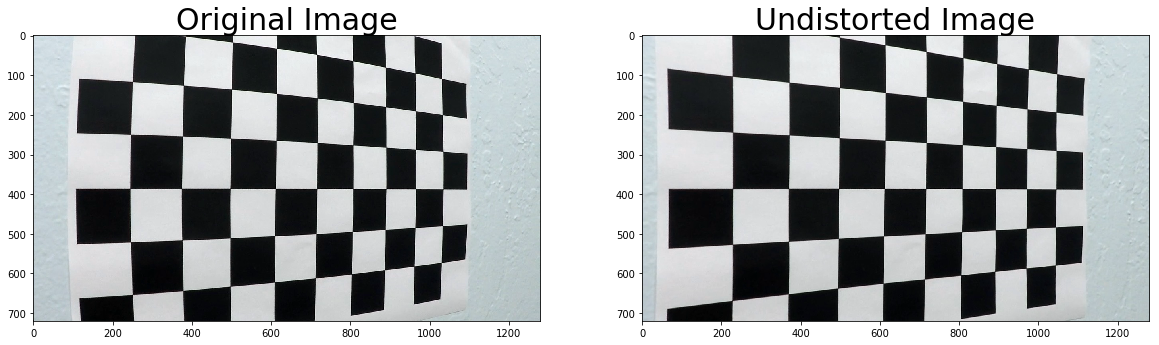

In [7]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [74]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_ransac(img, lines, color=[255, 0, 0], thickness=10):
    img2 = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    left_x = []
    left_y = []
    right_x = []
    right_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            # dis = math.sqrt((y2-y1)*(y2-y1) + (x2-x1)*(x2-x1))
            # if dis < 10:
            #     continue
            slope = math.atan2((y2 - y1), (x2 - x1)) * 57.3
            # if (abs(abs(slope) - 90) < 5):
            #     print('skip %f' % slope)
            #     continue
            # if (abs(slope) < 5):
            #     print('skip %f' % slope)
            #     continue
            if slope > 0:
                # right
                right_x.append([x1]),right_x.append([x2])
                right_y.append(y1),right_y.append(y2)
            elif slope < 0:
                # left
                left_x.append([x1]), left_x.append([x2])
                left_y.append(y1), left_y.append(y2)
    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(left_x, left_y)
    left_inlier_mask = model_ransac.inlier_mask_
    left_outlier_mask = np.logical_not(left_inlier_mask)
    # find left far, near points in the inliner points
    left_far_near_x = np.array([-999999, 999999])
    for i in range(left_inlier_mask.size):
        if np.equal(left_inlier_mask[i],True):
            # far point x
            if left_x[i][0] > left_far_near_x[0]:
                left_far_near_x[0] = left_x[i][0]
            # near point x
            if left_x[i][0] < left_far_near_x[1]:
                left_far_near_x[1] = left_x[i][0]
    left_far_near_y = model_ransac.predict(left_far_near_x[:, np.newaxis])
    left_far_near_y = left_far_near_y.astype(np.int64)

    model_ransac2 = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac2.fit(right_x, right_y)
    right_inlier_mask = model_ransac2.inlier_mask_
    right_outlier_mask = np.logical_not(right_inlier_mask)
    right_far_near_x = np.array([999999, -999999])
    for i in range(right_inlier_mask.size):
        if np.equal(right_inlier_mask[i],True):
            if right_x[i][0] > right_far_near_x[1]:
                right_far_near_x[1] = right_x[i][0]
            if right_x[i][0] < right_far_near_x[0]:
                right_far_near_x[0] = right_x[i][0]
    right_far_near_y = model_ransac2.predict(right_far_near_x[:, np.newaxis])
    right_far_near_y = right_far_near_y.astype(np.int64)

    cv2.line(img2, (left_far_near_x[0], left_far_near_y[0]),
             (left_far_near_x[1], left_far_near_y[1]), color, thickness)
    cv2.line(img2, (right_far_near_x[0], right_far_near_y[0]),
             (right_far_near_x[1], right_far_near_y[1]), color, thickness)

    cv2.addWeighted(img2, 0.6, img, 0.4, 0., img)
    
def draw_lines_ori(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,is_ori = False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if is_ori:
        draw_lines_ori(line_img, lines)
    else:
        draw_lines_ransac(line_img, lines)
    return line_img

In [161]:
def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    
def unwarp(img, src_corners, dst_corners):
    print('asdf')
#     # Pass in your image into this function
#     # Write code to do the following steps
#     # 1) Undistort using mtx and dist
    
# #     f, ax1 = plt.subplots(1, 1, figsize=(20,10))
# #     ax1.set_title('Undistorted Image', fontsize=30)
# #     ax1.imshow(dst)
#     # 2) Convert to grayscale
#     gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
# #     f, ax1 = plt.subplots(1, 1, figsize=(20,10))
# #     ax1.set_title('gray Image', fontsize=30)
# #     ax1.imshow(gray)

        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])

             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code

        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # M = None
    # warped = np.copy(img) 
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv




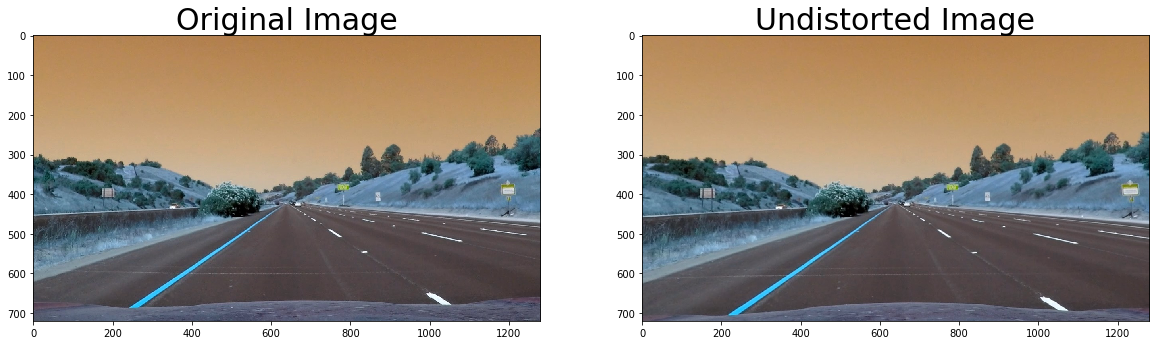

In [173]:
img = cv2.imread('test_images/straight_lines1.jpg')
# img = cv2.imread('test_images/test2.jpg')
nx = chess_grid_width # the number of inside corners in x
ny = chess_grid_height # the number of inside corners in y
# print('img')
# print(img)

# print('mtx')
# print(mtx)
# print('dist')
# print(dist)

undist = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


img = undist

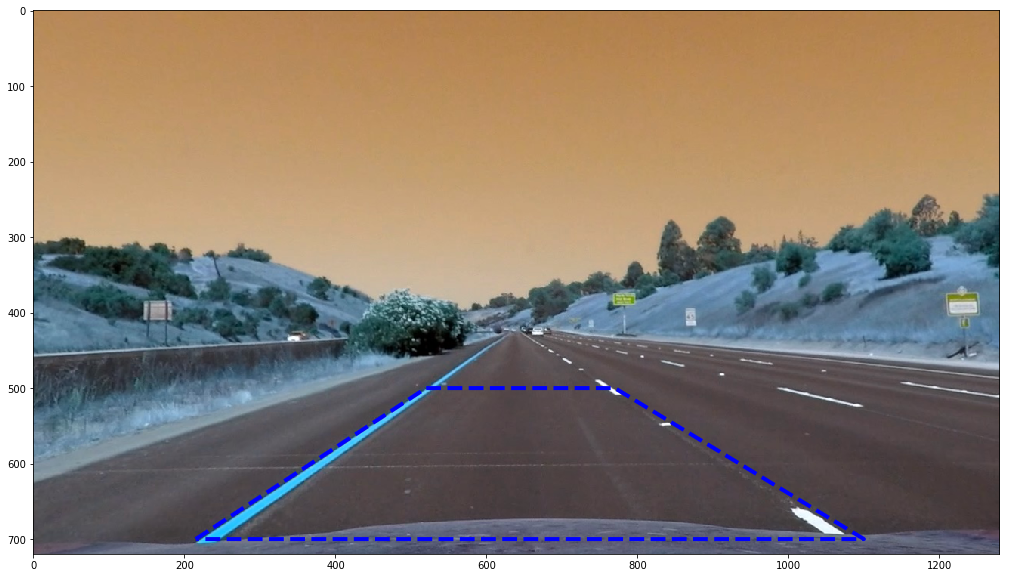

In [138]:
left_bottom = [215,700]
left_top = [520,500]
right_top = [770,500]
right_bottom = [1100,700]
src = np.float32([left_top,right_top,left_bottom,right_bottom])
# Source coordinates
image_width = img.shape[1]
image_height = img.shape[0]
src = np.float32([
        [image_width * 0.4475, image_height * 0.65],
        [image_width * 0.5525, image_height * 0.65],
        [image_width * 0.175, image_height * 0.95],
        [image_width * 0.825, image_height * 0.95],
    ])

# Destination coordinates
dst = np.float32([
        [image_width * 0.2, image_height * 0.025],
        [image_width * 0.8, image_height * 0.025],
        [image_width * 0.2, image_height * 0.975],
        [image_width * 0.8, image_height * 0.975],
    ])

x = [left_bottom[0], left_top[0], right_top[0], right_bottom[0], left_bottom[0]]
y = [left_bottom[1], left_top[1], right_top[1], right_bottom[1], left_bottom[1]]
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b--', lw=4)
plt.imshow(img)
plt.show()
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
# dst = np.float32([[100,500],[1200,500],[100,700],[1200,700]])

asdf


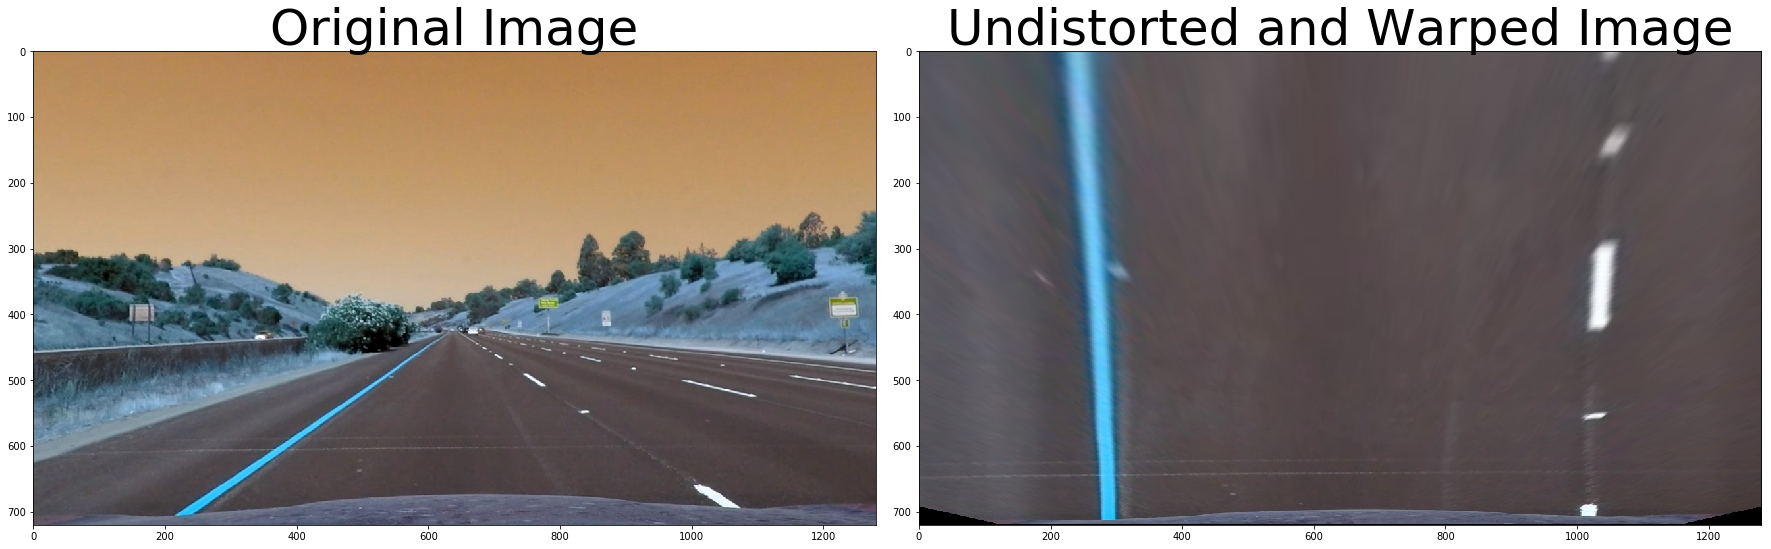

In [162]:
top_down, perspective_M, Minv = unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [163]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(100, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_channel = np.uint8(255*s_channel/np.max(s_channel))
#     print('s_channel')
#     print(s_channel)
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
#     return s_binary
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#     print('color_binary')
    #     print(color_binary)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#     print(combined_binary)
    return color_binary, combined_binary

<function __main__.f>

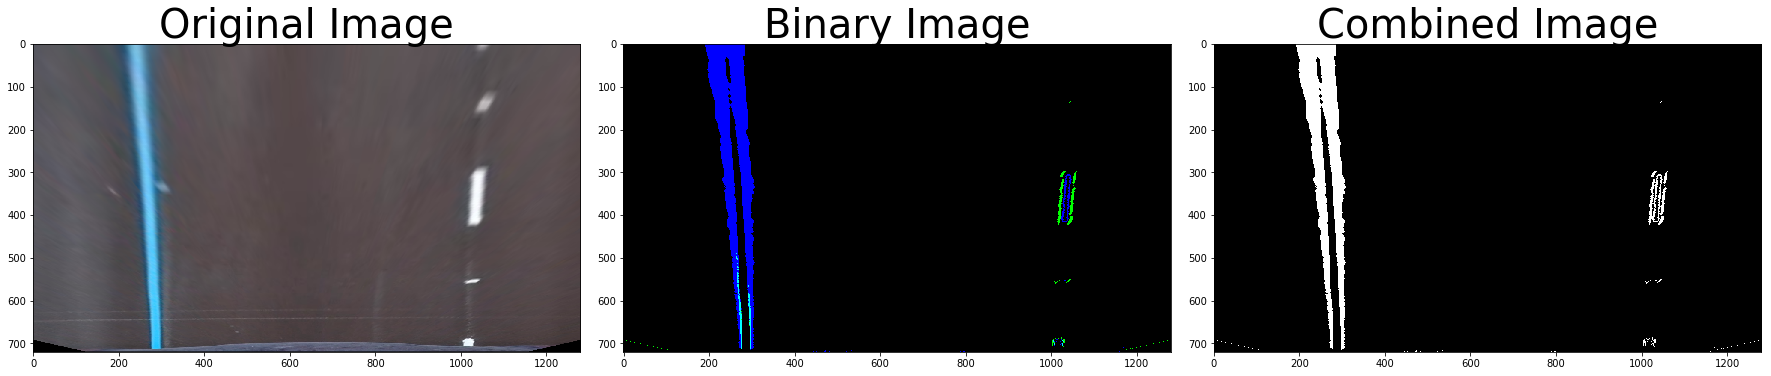

In [164]:


def f(s_max,s_min,sx_max,sx_min):
#     binary_img = pipeline(top_down, s_thresh=(30, 255), sx_thresh=(150, 255))
    binary_img, combined_binary = pipeline(top_down, s_thresh=(s_min, s_max), sx_thresh=(sx_min, sx_max))

    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(top_down)
    ax1.set_title('Original Image', fontsize=40)

    # print(result)
    ax2.imshow(binary_img)
    ax2.set_title('Binary Image', fontsize=40)
    
    ax3.imshow(combined_binary, cmap='gray')
    ax3.set_title('Combined Image', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# s_thresh=(30, 255), sx_thresh=(150, 255)
interact(f, s_max=(100,255,1), s_min=(0,100,1), sx_max=(100,255,1), sx_min=(0,100,1))
# straight1 228 70 168 26
# test1 226 90 213 93
# 177 50 177 50

360


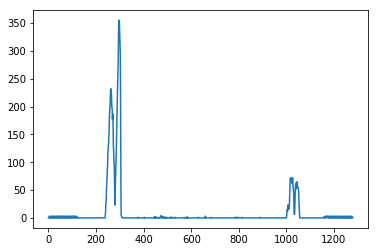

In [165]:
s_min = 50
s_max = 177
sx_min = 28
sx_max = 177

binary_img, combined_binary = pipeline(top_down, s_thresh=(s_min, s_max), sx_thresh=(sx_min, sx_max))
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

aa = combined_binary.shape[0]//2
print(aa)

In [166]:

binary_warped = combined_binary
# Create an output image to draw on and  visualize the result
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('leftx_base')
print(leftx_base)
print('rightx_base')
print(rightx_base)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
print('window_height')
print(window_height)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_base
297
rightx_base
1017
window_height
80


# solution 2

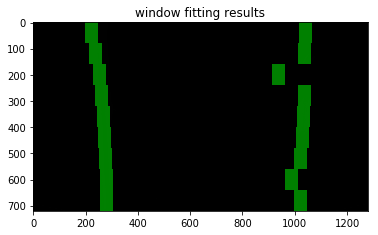

In [167]:
warped = combined_binary

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


(720, 0)

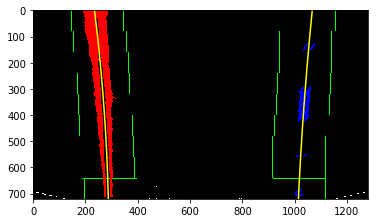

In [168]:
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#     print('good_left,right idx: {} {}'.format(good_left_inds,good_right_inds))
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Measuring Curvature

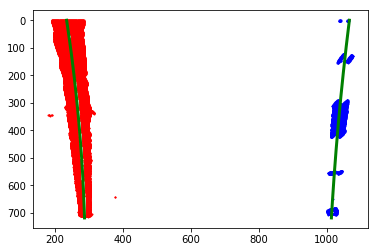

In [169]:
# Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 1
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images



In [170]:
# Calculates curvature given lane polynomial fit and bottom vertical point
def get_curvature(line_fit, y_eval):
    return ((1 + (2 * line_fit[0] * y_eval + line_fit[1]) ** 2) ** 1.5) \
                             / np.absolute(2 * line_fit[0])

yvalue = combined_binary.shape[0]
c = get_curvature(left_fit, yvalue)
print('cccccccc: {}'.format(c))

cccccccc: 7302.968082948333


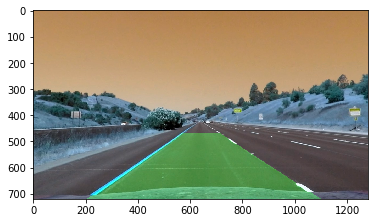

In [174]:
warped = combined_binary
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)